# Quick Start

### Installation

- Install from PYPI or from source.

```
pip install flowsaber
```

Or

```bash
https://github.com/zhqu1148980644/flowsaber.git
cd flowsaber && pip install .
```

### Main concepts

For users who are familiar with nextflow usages can skip this part, other's can also check
[this](https://www.nextflow.io/docs/edge/basic.html) for similar descriptions that comes from the introduction
section of the nextflow documentation.

Basically there are several components that are exposed to users for building and configuring workflows.

##### Task
`Task` is the object represents the execution unit in your workflow. Tasks runs in parallel for different inputs.

##### Flow
`Flow` is the object that combines and records dependencies of all tasks you have put in. After it's been
defined, it should be passed to `FlowRunner` for the actual dependency building and flow execution.

##### Channel
`Channel` represents a flow/queue of data, it's consumed by Tasks. Any user defined data should be
enqueued into a channel and then as arguments of Task/Flow.

##### Operator
`Operator` is built-in tasks that helps to manipulate the control of channels.

- For example: `map, sum, count, collect, flatten....`

### A Typical workflow

The workflow defined below covers most sets of features supported by pyflow.

- Note: the output of the workflow may be different in different runs, this is
due to the parallelism of task's executions for different inputs.

Output()

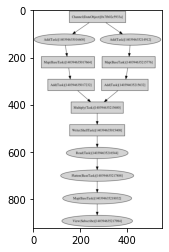

In [1]:
import sys

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

sys.path.insert(0, '../../')
from flowsaber import *


@task
def add(self, num):  # self is optional
    return num + 1


@task
def multiply(num1, num2):
    return num1 * num2


@shell
def write(num):
    """echo {num} > 1.txt"""
    return '*.txt'


@task
def read(f: File):
    return open(str(f)).readlines()


@flow
def sub_flow(num):
    return add(num) | map_(lambda x: x ** 2) | add


@flow
def my_flow(num):
    [sub_flow(num), sub_flow(num)] | multiply \
    | write | read | flatten \
    | map_(lambda x: int(x.strip())) \
    | view


config.update({
    'cpu': 8,
    Task: {
        'executor': 'local'  # for test, use simple one
    }
})

# set input
num_ch = Channel.values(1, 2, 3)
# resolve dependencies
runner, workflow = FlowRunner(my_flow).run(num=num_ch)
# now can generate dag
workflow.graph.render('workflow', view=False, format='png', cleanup=True)
# truly run the flow
await runner.aexecute()

# visualize the flow

img = mpimg.imread('workflow.png')
imgplot = plt.imshow(img)
plt.show(block=False)